# SD212: Graph mining
## Lab 6: Spectral embedding

In this lab, you will learn to embed the nodes of a graph in a vector space of low dimension. We consider the  embedding based on the top eigenvectors of the transition matrix $P=D^{-1}A$.

## Import

In [1]:
from IPython.display import SVG

In [2]:
import numpy as np
from scipy import sparse
from matplotlib import pyplot as plt

In [3]:
from sknetwork.data import load_netset, karate_club
from sknetwork.embedding import Spectral
from sknetwork.ranking import PageRank, top_k
from sknetwork.utils import KMeansDense, WardDense
from sknetwork.visualization import svg_graph, svg_dendrogram

## Data

We will work on the following graphs (see the [NetSet](https://netset.telecom-paris.fr/) collection for details):
* Openflights (graph)
* WikiVitals (directed graph and bipartite graph)

In [4]:
openflights = load_netset('openflights')
wikivitals = load_netset('wikivitals')

Parsing files...
Done.
Parsing files...
Done.


## 1. Graphs

## Karate Club


We first consider the spectral embedding of the [karate club graph](https://en.wikipedia.org/wiki/Zachary%27s_karate_club).

In [5]:
graph = karate_club(metadata=True)

In [6]:
adjacency = graph.adjacency
position = graph.position
labels_true = graph.labels

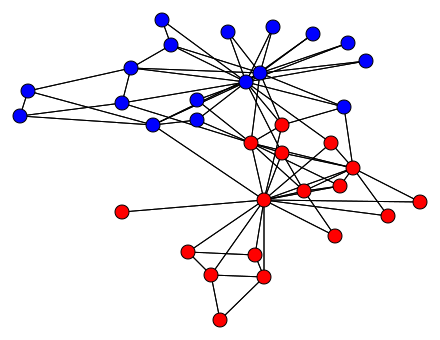

In [7]:
image = svg_graph(adjacency, position, labels=labels_true)
SVG(image)

## To do

* Display the spectrum of the transition matrix (e.g., first 30 eigenvalues). 
* What does the spectrum suggest?
* Display the embedding of the graph in dimension 2.
* Check that the embedding weighted by the degrees is centered.
* How many nodes are misclassified using the sign of the first eigenvector? What are these nodes?

In [8]:
spectral = Spectral(30, normalized=False)

In [9]:
# fit_transform
embedding = spectral.fit_transform(adjacency)

In [10]:
# or fit
spectral.fit(adjacency)
emebdding = spectral.embedding_

In [11]:
embedding.shape

(34, 30)

In [12]:
# add first eigenvalue
eigenvalues = [1] + list(spectral.eigenvalues_)

(-1.1, 1.1)

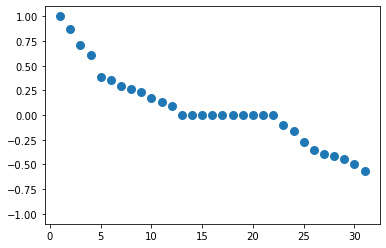

In [13]:
plt.scatter(np.arange(len(eigenvalues)) + 1, eigenvalues, lw=3)
plt.ylim(-1.1, 1.1)

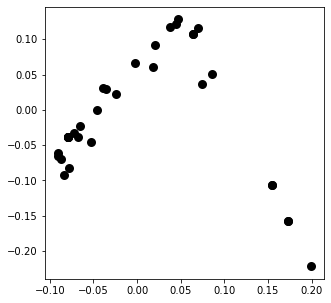

In [14]:
plt.figure(figsize=(5,5))
plt.scatter(embedding[:,0], embedding[:,1], lw=3, color='k')

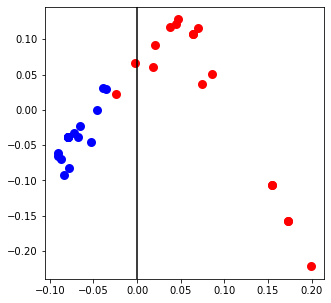

In [15]:
plt.figure(figsize=(5,5))
plt.scatter(embedding[labels_true==0,0], embedding[labels_true==0,1], lw=3, color='blue')
plt.scatter(embedding[labels_true==1,0], embedding[labels_true==1,1], lw=3, color='red')
plt.axvline(color='k')

In [16]:
labels_pred = embedding[:,0] > 0

In [17]:
np.sum(labels_pred!=labels_true)

2

## Openflights


We now consider a larger graph. We use spectral embedding in dimension 20 to cluster the graph by k-means in the embedding space.

In [18]:
graph = openflights

In [19]:
adjacency = graph.adjacency
position = graph.position
names = graph.names

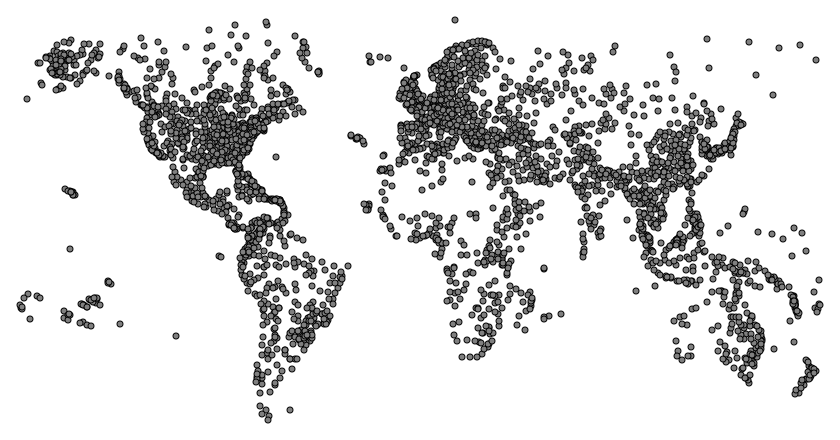

In [20]:
image = svg_graph(adjacency, position, width=800, height=400, node_size=3, display_edges=False)
SVG(image)

## To do

* Display the same world map with 8 clusters found by k-means in the embedding space.
* Do the same without normalization on the unit sphere (``normalized=False``).<br> Interpret the results. You might compute the distance of the barycenter of each cluster to the origin.

In [21]:
spectral = Spectral(20, normalized=False)

In [22]:
embedding = spectral.fit_transform(adjacency)

In [23]:
kmeans = KMeansDense(8)

In [24]:
labels = kmeans.fit_transform(embedding)

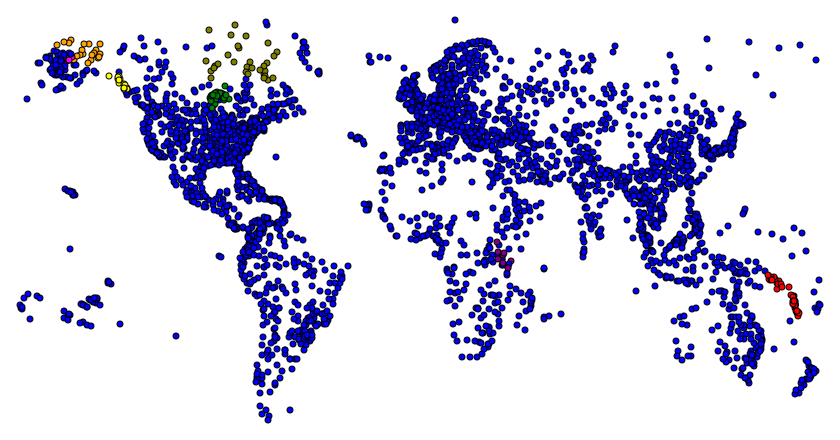

In [25]:
image = svg_graph(adjacency, position, labels=labels, width=800, height=400, node_size=3, display_edges=False)
SVG(image)

## 2. Directed graphs and bipartite graphs

We now work on directed graph and bipartite graphs. We measure proximity between nodes in terms of [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity). Equivalently, we consider the embedding on the unit sphere (``normalized=True``).

## Wikipedia Vitals

In [26]:
graph = wikivitals

In [27]:
adjacency = graph.adjacency
biadjacency = graph.biadjacency
names = graph.names
words = graph.names_col
labels = graph.labels
names_labels = graph.names_labels
labels_hierarchy = graph.labels_hierarchy
names_labels_hierarchy = graph.names_labels_hierarchy

## To do

We first consider the graph of links.

* List the 10 articles that are closest to **Vincent van Gogh** in terms of cosine similarity in the embedding space.
* Display the 3D-plot of of the barycenter of each label in the embedding space (first 3 components).
* Display the dendrogram of the top-100 articles on **Arts** (in terms of Personalized PageRank) given by the Ward method in the embedding space.

In [28]:
spectral = Spectral(20)

In [29]:
embedding = spectral.fit_transform(biadjacency)

In [30]:
embedding_col = spectral.embedding_col_

In [31]:
embedding.shape

(10011, 20)

In [32]:
# check normalization
np.linalg.norm(embedding, axis=1)

array([1., 1., 1., ..., 1., 1., 1.])

In [33]:
# cosine similarity = dot product between unit vectors
sims = embedding.dot(embedding[names=='Vincent van Gogh'].ravel())

In [34]:
names[top_k(sims, 10)]

array(['Vincent van Gogh', 'Edvard Munch', 'Arthur Rimbaud',
       'Henri Rousseau', 'Claude Monet', 'Victor Hugo',
       'Henri de Toulouse-Lautrec', 'Camille Pissarro', 'Franz Kafka',
       'John Singer Sargent'], dtype='<U62')

In [35]:
sims[top_k(sims, 10)]

array([1.        , 0.97411308, 0.94835384, 0.94788867, 0.93727677,
       0.93277019, 0.93274154, 0.93272524, 0.92995188, 0.9292887 ])

In [36]:
# cosine similarity with words
sims_words = embedding_col.dot(embedding[names=='Vincent van Gogh'].ravel())

In [37]:
words[top_k(sims_words, 10)]

array(['Fauves', 'Rimbaud', 'aestheticism', 'transgressive', 'bizarre',
       'disillusionment', 'wit', 'Expressionists', 'decadent',
       'printmaker'], dtype='<U26')

In [38]:
sims = embedding.dot(embedding_col[words=='painting'].ravel())

In [39]:
names[top_k(sims, 10)]

array(["Les Demoiselles d'Avignon", 'Hieronymus Bosch', 'Rembrandt',
       'Modern art', 'Peter Paul Rubens', 'Gian Lorenzo Bernini',
       'Symbolism (arts)', 'Constantin Brâncuși',
       'Pieter Bruegel the Elder', 'Johannes Vermeer'], dtype='<U62')

In [40]:
sims = embedding_col.dot(embedding_col[words=='painting'].ravel())

In [41]:
words[top_k(sims, 50)]

array(['painting', 'Rembrandt', 'Netherlandish', 'Bruegel', 'Painters',
       'Demoiselles', 'Rubens', 'portraiture', 'draughtsman', 'Vermeer',
       'Lautrec', 'ˈpitər', 'masterly', 'Eyck', 'Picasso', 'Derain',
       'cubist', 'Brâncuși', 'etching', 'portrait', 'Rodin', 'Gombrich',
       'Altarpiece', 'painter', 'Braque', 'collage', 'Matisse',
       'altarpiece', 'woodcut', 'collé', 'illusionism', 'Thinker', 'alla',
       'Degas', 'Fauvism', 'Manet', 'watercolour', 'pastiche',
       'Quattrocento', 'sculptor', 'Cézanne', 'artistic', 'cubism',
       'Delights', 'printmaker', 'Salon', 'Impressionism', 'Vasari',
       'Metzinger', 'Gleizes'], dtype='<U26')

In [42]:
labels_unique, counts = np.unique(labels, return_counts=True)

In [43]:
barycenters = [np.mean(embedding[labels==label], axis=0) for label in labels_unique]

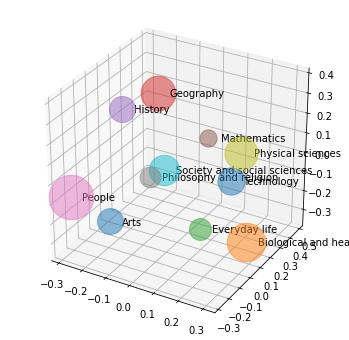

In [44]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
for i, barycenter in enumerate(barycenters):
    ax.scatter(barycenter[0], barycenter[1], barycenter[2], s=counts[i], alpha=0.5)
for i, barycenter in enumerate(barycenters):
    ax.text(barycenter[0]+0.05, barycenter[1], barycenter[2], names_labels[i])

In [45]:
distances = [np.linalg.norm(barycenter) for barycenter in barycenters]

In [46]:
names_labels[np.argsort(distances)]

array(['People', 'Society and social sciences', 'History',
       'Physical sciences', 'Everyday life',
       'Biological and health sciences', 'Arts', 'Technology',
       'Philosophy and religion', 'Geography', 'Mathematics'],
      dtype='<U30')

In [47]:
names_labels[np.argsort(distances)]

array(['People', 'Society and social sciences', 'History',
       'Physical sciences', 'Everyday life',
       'Biological and health sciences', 'Arts', 'Technology',
       'Philosophy and religion', 'Geography', 'Mathematics'],
      dtype='<U30')

In [48]:
np.array(distances)[np.argsort(distances)]

array([0.43872669, 0.49322005, 0.49421653, 0.50013122, 0.52662638,
       0.52798766, 0.53844929, 0.61283731, 0.69864452, 0.740269  ,
       0.91571285])

In [49]:
# average cosine similarity per label
np.array(distances)[np.argsort(distances)]**2

array([0.19248111, 0.24326602, 0.24424998, 0.25013124, 0.27733534,
       0.27877097, 0.28992764, 0.37556957, 0.48810416, 0.54799819,
       0.83853002])

## To do

* Repeat the same experiments of the bipartite graph between articles and words.
* List the 10 articles and the 10 words that are closest to the word **painting** in the embedding space.

## To do

* Check that the average cosine similarity between nodes in some set $S$ is given by the square distance of the barycenter of $S$ to the origin.

For the following questions, first consider the graph of links, then the bipartite graph between articles and words:

* Compute the average cosine similarity between articles of the **Mammals** category (see hierarchical labels).
* Compare with the expected cosine similarity between two articles sampled uniformly at random.
* Defining a category as **topical** if its average cosine similarity is close to 1, rank the 11 categories (Arts, History,...) by topicality. 
* List the 10 most topical and the 10 less topical hierarchical categories having at least 10 articles (like **Mammals**). 

In [50]:
names_labels

array(['Arts', 'Biological and health sciences', 'Everyday life',
       'Geography', 'History', 'Mathematics', 'People',
       'Philosophy and religion', 'Physical sciences',
       'Society and social sciences', 'Technology'], dtype='<U30')

In [51]:
names_labels_hierarchy

array(['Arts|||Architecture|||General',
       'Arts|||Architecture|||Specific structures',
       'Arts|||Architecture|||Specific structures|||Seven Wonders of the Ancient World',
       ..., 'Technology|||Transportation|||Road transport|||Driving',
       'Technology|||Transportation|||Road transport|||Road',
       'Technology|||Transportation|||Road transport|||Road|||Highway'],
      dtype='<U142')

In [52]:
mammals = {i: name for i, name in enumerate(names_labels_hierarchy) if 'Mammals' in name}

In [53]:
# mammals
barycenter = np.mean(embedding[np.isin(labels_hierarchy, list(mammals))], axis=0)

In [54]:
np.linalg.norm(barycenter)**2

0.854417453011309

In [55]:
# all articles
barycenter = np.mean(embedding, axis=0)

In [56]:
np.linalg.norm(barycenter)**2

0.006870975506168389

In [57]:
labels_hierarchy_unique, counts = np.unique(labels_hierarchy, return_counts=True)

In [58]:
top_labels = labels_hierarchy_unique[counts >= 10]

In [59]:
distances = []
for label in top_labels:
    barycenter = np.mean(embedding[labels_hierarchy==label], axis=0)
    distances.append(np.linalg.norm(barycenter)**2)

In [60]:
distances = np.array(distances)

In [61]:
names_labels_hierarchy[top_labels[top_k(distances, 10)]]

array(['People|||Sports figures|||Team sports|||Association football',
       'Physical sciences|||Astronomy|||Astronomical objects|||Notable stars',
       'Mathematics|||Algebra|||Abstract algebra',
       'Mathematics|||Geometry|||Topology',
       'People|||Musicians and composers|||Western art music|||Composers|||20th century modern',
       'Philosophy and religion|||Eastern religions|||Hinduism',
       'Arts|||Modern visual arts|||Filmmaking|||Films|||Drama film',
       'People|||Musicians and composers|||Popular music|||Rock',
       'Everyday life|||Sports and recreation|||Sports|||Athletics|||Track and field',
       'Biological and health sciences|||Health, medicine and disease|||Morbidity|||Mental disorder'],
      dtype='<U142')

In [62]:
distances[top_k(distances, 10)]

array([0.99217956, 0.98192326, 0.98073806, 0.98034978, 0.97496687,
       0.97450479, 0.9699673 , 0.96236904, 0.96098452, 0.9605376 ])

In [63]:
names[labels_hierarchy==top_labels[top_k(distances, 1)]]

array(['Alfredo Di Stéfano', 'Cristiano Ronaldo', 'Diego Maradona',
       'Eusébio', 'Ferenc Puskás', 'Franz Beckenbauer', 'Johan Cruyff',
       'Lev Yashin', 'Lionel Messi', 'Mia Hamm', 'Michel Platini', 'Pelé',
       'Ronaldo (Brazilian footballer)', 'Zinedine Zidane'], dtype='<U62')

In [64]:
names_labels_hierarchy[top_labels[top_k(-distances, 10)]]

array(['Arts|||Architecture|||Specific structures',
       'History|||History by subject matter',
       'History|||Modern history|||General',
       'People|||Writers|||Post-classical|||Asia',
       'People|||Military leaders and theorists|||Post-classical history',
       'People|||Scientists, inventors and mathematicians|||Life sciences|||General',
       'Society and social sciences|||Business and economics|||General|||Property',
       'People|||Scientists, inventors and mathematicians|||Ancient figures|||Post-classical',
       'Everyday life|||Sports and recreation|||Entertainment|||Entertainment and leisure',
       'History|||History by country|||Asia'], dtype='<U142')

In [65]:
names[labels_hierarchy==top_labels[top_k(-distances, 1)]]

array(['Acropolis of Athens', 'Alhambra', 'Angkor Wat', 'Arc de Triomphe',
       'Borobudur', 'Burj Khalifa', 'Chartres Cathedral', 'Colosseum',
       'Eiffel Tower', 'Empire State Building', 'Fallingwater',
       'Florence Cathedral', 'Forbidden City', 'Great Sphinx of Giza',
       'Great Wall of China', 'Guggenheim Museum Bilbao', 'Hagia Sophia',
       'Kaaba', 'Kinkaku-ji', 'Leaning Tower of Pisa', 'Machu Picchu',
       'Moscow Kremlin', 'Notre-Dame de Paris', 'Palace of Versailles',
       'Palace of Westminster', 'Pantheon, Rome', 'Parthenon',
       'Sagrada Família', 'Seven Wonders of the Ancient World',
       "St. Peter's Basilica", 'Statue of Liberty', 'Stonehenge',
       'Sydney Opera House', 'Taj Mahal', 'Temple Mount',
       'Ziggurat of Ur'], dtype='<U62')